<a href="https://colab.research.google.com/github/ethan-yoo/DACON_Contest/blob/main/Daycon_SecondhandedCar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **데이콘 중고차 가격 예측 대회**

>**train.csv**
---



feature | 내용||
:--|:--|:--
id | 샘플 아이디
title |제조사 모델명
odometer | 주행 거리
location | 판매처(나이지리아 도시)
isimported | 현지 사용 여부
engine | 엔진 종류
transmission | 트랜스미션 종류
fuel | 연료 종류
paint | 페인트 색상
year | 제조년도
target | 자동차 가격




>**test.csv**
---
feature | 내용
:--|:--
id | 샘플 아이디
title | 제조사 모델명
odometer | 주행 거리
location | 판매처(나이지리아 도시)
isimported | 현지 사용 여부
engine | 엔진 종류
transmission | 트랜스미션 종류
fuel | 연료 종류
paint | 페인트 색상
year | 제조년도


>**sample_submission.csv**
---
feature | 내용
:--|:--
id | 샘플 아이디
target | 자동차 가격


---

## **데이터 로드**

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [812]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import tensorflow as tf
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder

print('Done!')

Done!


In [682]:
train_data = pd.read_csv('/content/drive/MyDrive/Dacon/중고차 가격예측/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Dacon/중고차 가격예측/test.csv')

print('Done!')

Done!


In [683]:
train_data.head()

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target
0,0,Toyota RAV 4,18277,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Red,2016,13665000
1,1,Toyota Land Cruiser,10,Lagos,New,4-cylinder(I4),automatic,petrol,Black,2019,33015000
2,2,Land Rover Range Rover Evoque,83091,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2012,9915000
3,3,Lexus ES 350,91524,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Gray,2007,3815000
4,4,Toyota Venza,94177,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2010,7385000


In [684]:
test_data.head()

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year
0,0,Mercedes-Benz C 300,1234,Abuja,New,4-cylinder(I4),automatic,petrol,White,2017
1,1,Honda Accord,29938,Abuja,Foreign Used,4-cylinder(I4),automatic,petrol,White,2013
2,2,Mercedes-Benz S 550,87501,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Black,2012
3,3,Toyota Sienna,180894,Lagos,Locally used,6-cylinder(V6),automatic,petrol,Dark Grey,2001
4,4,Toyota Hiace,104814,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,White,2000


In [685]:
print(train_data.shape)
print(test_data.shape)

(1015, 11)
(436, 10)


## **train, test 데이터 생성**

train 데이터 수가 적어서 과적합 되지 않게 조심해야 합니다.


In [686]:
X = train_data.copy()

In [687]:
X.head()

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target
0,0,Toyota RAV 4,18277,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Red,2016,13665000
1,1,Toyota Land Cruiser,10,Lagos,New,4-cylinder(I4),automatic,petrol,Black,2019,33015000
2,2,Land Rover Range Rover Evoque,83091,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2012,9915000
3,3,Lexus ES 350,91524,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Gray,2007,3815000
4,4,Toyota Venza,94177,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2010,7385000


In [688]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1015 entries, 0 to 1014
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1015 non-null   int64 
 1   title         1015 non-null   object
 2   odometer      1015 non-null   int64 
 3   location      1015 non-null   object
 4   isimported    1015 non-null   object
 5   engine        1015 non-null   object
 6   transmission  1015 non-null   object
 7   fuel          1015 non-null   object
 8   paint         1015 non-null   object
 9   year          1015 non-null   int64 
 10  target        1015 non-null   int64 
dtypes: int64(4), object(7)
memory usage: 87.4+ KB


모델 사용시에는 object 값들을 숫자로 바꿔줘야 할 겁니다.

일단 각 컬럼을 조금 더 상세하게 살펴보겠습니다.

---

## **결측치 확인**

In [689]:
X.isna().sum()

id              0
title           0
odometer        0
location        0
isimported      0
engine          0
transmission    0
fuel            0
paint           0
year            0
target          0
dtype: int64

In [690]:
test_data.isna().sum()

id              0
title           0
odometer        0
location        0
isimported      0
engine          0
transmission    0
fuel            0
paint           0
year            0
dtype: int64

결측치는 없습니다.

---

## **columns 분석**

### **Uniqueness**

In [691]:
X.columns

Index(['id', 'title', 'odometer', 'location', 'isimported', 'engine',
       'transmission', 'fuel', 'paint', 'year', 'target'],
      dtype='object')

In [692]:
print('Uniqueness')
for col in X.columns:
    print(col, ":", len(X[col].unique()))

Uniqueness
id : 1015
title : 203
odometer : 985
location : 13
isimported : 3
engine : 8
transmission : 2
fuel : 2
paint : 76
year : 33
target : 394


id만 unique하고 나머지는 중복값이 존재합니다.

---

### **id**

id 열은 인덱스 역할을 하고 있습니다.

자료형도 바꿔줄 필요가 없으니 넘어갑니다.

In [693]:
type(X['id'][1])

numpy.int64

---

### **title**

대회 안내에서는 제조사 모델명이라고 되어 있습니다.

차종에 대한 정보가 들어 있습니다. 당연히 차종에 따라 가격이 바뀔 것입니다.

In [694]:
len(X['title'].unique())

203

In [695]:
len(X['target'].unique())

394

두 컬럼이 가진 유니크 값의 개수가 다릅니다.

title의 값 개수가 더 적으므로, 같은 차종에서도 다른 가격을 갖는 요인이 존재합니다.

title 컬럼의 분포 그래프를 살펴보겠습니다.

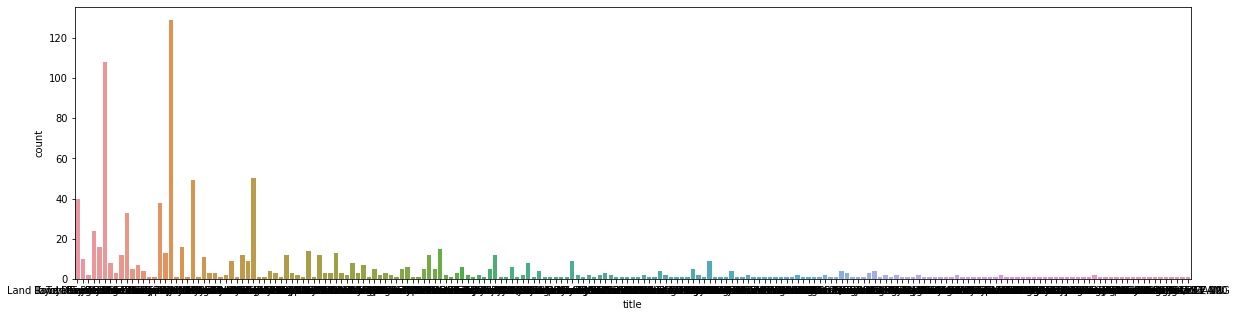

In [696]:
# title 분포
plt.figure(figsize=(20,5))
sns.countplot(data=X, x='title')
plt.show()

특별히 자주 거래되는 차종들이 존재하는 것을 확인할 수 있습니다.

인기가 많은 TOP 10 차종을 뽑아보겠습니다.

In [697]:
vehicle_popularity = X['title'].value_counts()
top_10 = vehicle_popularity[:10]
top_10

Toyota Camry         129
Toyota Corolla       108
Toyota Highlander     50
Toyota Sienna         49
Toyota RAV 4          40
Honda Accord          38
Lexus RX 350          33
Lexus ES 350          24
Toyota Venza          16
Lexus GX 460          16
Name: title, dtype: int64

In [698]:
print('전체 차종별 평균 거래 횟수: {}회'.format(vehicle_popularity.mean()))

전체 차종별 평균 거래 횟수: 5.0회


In [699]:
print('top 10 차종의 평균 거래 횟수: {}회'.format(top_10.mean()))

top 10 차종의 평균 거래 횟수: 50.3회


In [700]:
print('전체에서 top 10 차종이 차지하는 거래 비율: {}%'.format(round((top_10.sum())/len(X)*100, 2)))

전체에서 top 10 차종이 차지하는 거래 비율: 49.56%


상위 10개 차종의 평균 거래 횟수는 전체 평균의 10배가 넘고, 전체 거래량의 반절 가까운 비중을 차지합니다.

전체 데이터 수가 적기 때문에, 거래량이 적은 차량의 경우에는 가격 예측이 어려울 수 있습니다.

혹은 아직 데이터에 없는 신규 차량이 매물로 나올 수도 있겠죠.

top 10 차종과 나머지 차종들의 가격 분포를 비교해보겠습니다.

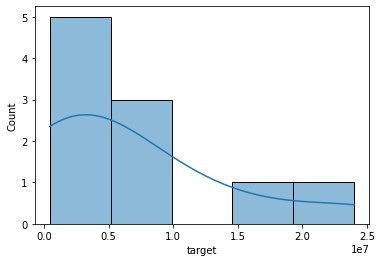

In [701]:
# top 10 차종
top10_pop = X.loc[top_10]

# 분포 그래프
sns.histplot(top10_pop['target'], kde=True)

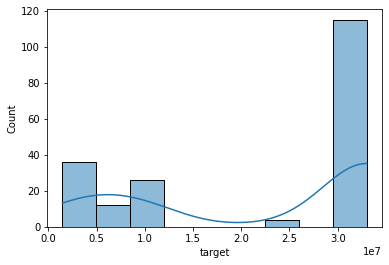

In [702]:
# 나머지 차종
less_pop = X.loc[vehicle_popularity][10:]
sns.histplot(less_pop['target'], kde=True)           

거래량이 많은 차종의 경우, 저가형 차량이 많이 팔리고 중고가 차량이 적게 팔리는 경향이 있습니다.

이는 직관적으로 이해할 수 있는 부분입니다.

하지만 거래량이 적은 차종들은 고가형 차량이 많이 팔리는 경향이 있습니다.

고가라서 거래량이 적은 걸까요, 아니면 거래량이 적어서 고가인 걸까요?

그도 아니면 다른 이유가 있을 지도 모릅니다.

하지만 아직 범주형 데이터나 문자열 데이터의 변환 작업도 하지 않았기 때문에, 

지금은 거래량과 가격 분포에 대한 인사이트만 가지고 넘어가겠습니다.

거래량이 적은 차종은 추후 데이터 증강을 해주어야 할 수도 있습니다.

---

### **odometer**

`odometer`는 주행거리를 나타내는 컬럼입니다.

많이 탄 차량일수록 가격이 낮아지는 게 정상이겠죠.

두 변수의 상관관계를 살펴보겠습니다.

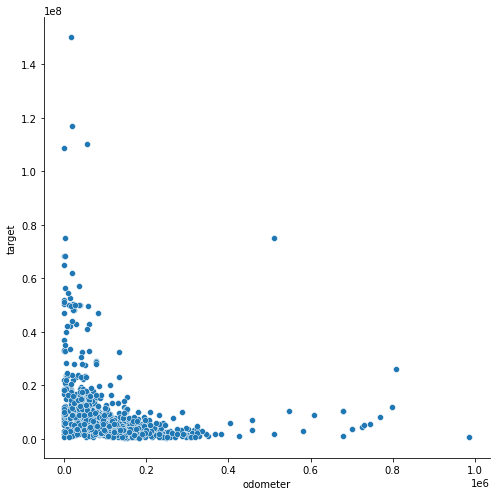

In [703]:
sns.relplot(data=X, x='odometer', y='target', height=7)

예상했던 대로, odometer 값이 증가하면 target 값이 감소하는 경향이 있습니다.

그런데 중간에 odometer 값이 비슷한 다른 차량 대비 가격이 높은 차량이 하나 보입니다.

혹시 이상치인지 확인해보겠습니다.

In [704]:
X.loc[((X['odometer'] > 0.4*1e6) & (X['target'] > 0.6*1e8))]

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target
827,827,Mercedes-Benz/52,510053,Lagos,Locally used,6-cylinder(V6),manual,diesel,white,1217,75015000


odometer, year, target 모두 값이 이상합니다.

아마 오기입이겠지만, 어쨌든 이상치이고 한 개 값밖에 없으니 지워줍니다.

In [705]:
X = X.drop(827)

그래프 상으로는 별 문제가 없어 보이지만, 혹시 모르니 양 끝값도 확인해보겠습니다.

In [706]:
X.loc[(X['target'] > 1.4*1e8)]

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target
597,597,Rolls-Royce Ghost,16069,Lagos,Locally used,4-cylinder(I4),automatic,petrol,Black,2011,150015008


In [707]:
X.loc[(X['odometer'] > 0.9*1e6)]

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target
190,190,Toyota Sienna,987322,Lagos,Locally used,6-cylinder(V6),automatic,petrol,Gold,2000,765000


롤스로이스 고스트는 신차 가격이 5.5억이 넘는 초 고가 차량입니다.

토요타 시에나도 주행거리를 생각하면 납득이 가는 가격대입니다.

(사실 저만큼 탔으면 그냥 폐차하는게 맞지 않나 싶습니다만....)

odometer 800000 근처에 비교적 비싼 값에 거래된 차량이 하나 더 있군요. 확인해 보겠습니다.



In [708]:
X.loc[((X['odometer'] > 0.8*1e6) & (X['target'] > 0.2*1e8))]

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target
1009,1009,Man BOCKMANN,809456,Lagos,Locally used,6-cylinder(V6),manual,diesel,white,1980,26015000


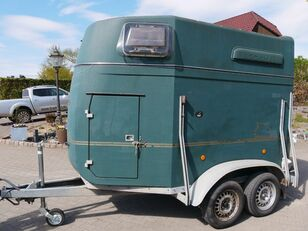

찾아보니 오래된 말 운반용 트럭입니다.

나름대로 비쌀 만한 이유가 있네요.

이제 인덱스 리셋을 해주고, 상관관계 그래프를 그려봅니다.

In [709]:
X = X.reset_index(drop=True)

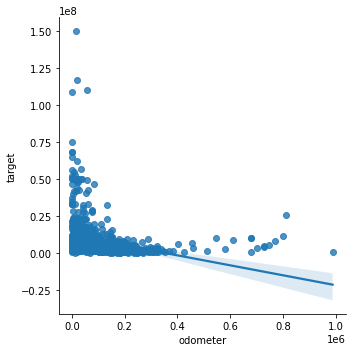

In [710]:
sns.lmplot(data=X, x='odometer', y='target')

추세선이 우하단 방향으로 그려지는 걸 통해 가설대로 두 변수간에 반비례 관계가 있다는 것을 알 수 있습니다.

---

### **location**

`location` 데이터는 판매처(나이지리아 도시) 정보 입니다.

특정 도시에서 차값이 비싸거나 저렴할 수도 있을 겁니다.

In [711]:
len(X['location'].unique())

13

총 13개의 도시에서 거래된 내역들입니다.

마찬가지로 거래 빈도를 확인해 보겠습니다.

In [712]:
X['location'].value_counts()

Lagos          791
Abuja          146
Ogun            26
Lagos           23
Lagos State     16
other            4
FCT              2
Accra            1
Abuja            1
Abia State       1
Adamawa          1
Abia             1
Ogun State       1
Name: location, dtype: int64

같은 도시인데 다른 unique 값으로 표현된 값들이 있습니다.

정규표현식을 사용해 일관성 있는 표현들로 바꿔주겠습니다.

함수를 만들어서 이후에도 사용합니다.

In [713]:
def clean_text(texts):
    corpus = [] 
    for i in range(0, len(texts)): 
        review = re.sub(r'[@%\\*=()/~#&\+á?\xc3\xa1\-\|\.\:\;\!\-\,\_\~\$\'\"\n\]\[\>\<]', '',texts[i]) #@%*=()/+ 와 같은 문장부호 제거
        review = re.sub(r'\d+','',review)
        review = review.lower()
        review = re.sub(r'state', '', review) # 뒤에 붙는 state 제거
        review = re.sub(r'\s+', ' ', review) # extra space 제거
        review = re.sub(r'<[^>]+>','',review) # Html tags 제거
        review = re.sub(r'\s+', ' ', review) # spaces 제거
        review = re.sub(r"^\s+", '', review) # space from start 제거
        review = re.sub(r'\s+$', '', review) # space from the end 제거
        review = re.sub(r'_', ' ', review) # space from the end 제거
        corpus.append(review) 
        
    return corpus

print('Done!')

Done!


In [714]:
X['location'] = clean_text(X['location'])

print('Done!')

Done!


In [715]:
X['location'].nunique()

8

In [716]:
X['location'].value_counts()

lagos      830
abuja      147
ogun        27
other        4
fct          2
abia         2
accra        1
adamawa      1
Name: location, dtype: int64

자연스럽게 정리가 되면서 다른 도시로 구분되었던 row 들도 합쳐진 것을 확인할 수 있습니다.

(fct는 나이지리아의 연방수도부 입니다.)

도시별로 가격 분포를 보겠습니다.

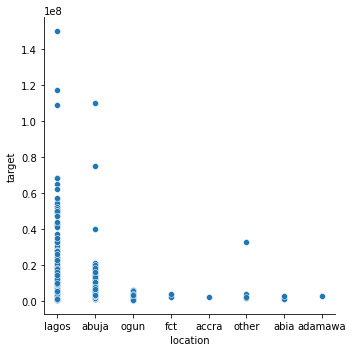

In [717]:
sns.relplot(data=X, x='location', y='target')

도시별로 특별하게 이상한 분포가 관측되지는 않습니다.

다음 컬럼을 살펴보겠습니다.

---

### **isimported**

현지 사용 여부 데이터입니다.

아마 해당 컬럼이 자동차의 감가상각에 큰 영향을 미칠 것 같습니다.

In [718]:
X['isimported'] = clean_text(X['isimported'])

In [719]:
len(X['isimported'].unique())

3

In [720]:
X['isimported'].value_counts()

foreign used    744
locally used    247
new              23
Name: isimported, dtype: int64

해외에서 수입해오는 중고차가 많군요.

지역별로 가격 분포를 살펴보겠습니다.


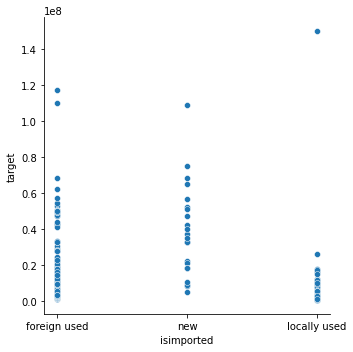

In [721]:
sns.relplot(data=X, x = 'isimported', y='target')

전반적으로 로컬 중고차가 해외 수입 중고차에 비해 저렴합니다.

각 지역별로 1~2개씩 이상치로 의심되는 거래 건이 존재합니다.

확인해 보겠습니다.

In [722]:
X.loc[((X['isimported'] == 'locally used') & (X['target'] > 1.4*1e8))]

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target
597,597,Rolls-Royce Ghost,16069,lagos,locally used,4-cylinder(I4),automatic,petrol,Black,2011,150015008


In [723]:
X.loc[(X['isimported'] == 'foreign used') & (X['target'] > 1e8)]

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target
341,341,Land Rover Range Rover Sport,18720,lagos,foreign used,8-cylinder(V8),automatic,petrol,Grey,2019,117015000
569,569,Lexus LX 570,55530,abuja,foreign used,8-cylinder(V8),automatic,petrol,Black,2014,110015000


In [724]:
X.loc[(X['isimported'] == 'new') & (X['target'] > 1e8)]

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target
736,736,Mercedes-Benz G 63 AMG,20,lagos,new,8-cylinder(V8),automatic,petrol,Black,2019,108690000


4개 차량 모두 고가의 차량들로, odometer까지 고려하면 이상치가 아니라고 판단할 수 있습니다.



---

### **engine**

In [725]:
len(X['engine'].unique())

8

In [726]:
X['engine'].value_counts()

4-cylinder(I4)    618
6-cylinder(V6)    221
6-cylinder(I6)    118
8-cylinder(V8)     49
3-cylinder(I3)      3
4-cylinder(H4)      2
5-cylinder(I5)      2
2-cylinder(I2)      1
Name: engine, dtype: int64

4기통 엔진을 가진 차량이 가장 많이 거래되었습니다.

1건뿐인 2기통 엔진은 어떤 차종일까요?

In [727]:
X.loc[X['engine']=='2-cylinder(I2)']

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target
868,869,Peugeot 308,130853,lagos,foreign used,2-cylinder(I2),manual,petrol,Brown,2009,3015000


09년식 푸조였습니다.

흠, 자세히 보니 괄호 안의 내용만으로도 몇 기통인지 구분이 가능할 것 같습니다.

변환해주도록 하겠습니다.

In [728]:
engine = X['engine']
engine.head()

0    4-cylinder(I4)
1    4-cylinder(I4)
2    6-cylinder(V6)
3    4-cylinder(I4)
4    6-cylinder(V6)
Name: engine, dtype: object

In [729]:
pattern = re.compile('\S\d')

engine_list = []
for i in range(len(engine)):
    engine_list = engine_list + pattern.findall(engine[i])

X['engine'] = engine_list
X.head()

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target
0,0,Toyota RAV 4,18277,lagos,foreign used,I4,automatic,petrol,Red,2016,13665000
1,1,Toyota Land Cruiser,10,lagos,new,I4,automatic,petrol,Black,2019,33015000
2,2,Land Rover Range Rover Evoque,83091,lagos,foreign used,V6,automatic,petrol,Red,2012,9915000
3,3,Lexus ES 350,91524,lagos,foreign used,I4,automatic,petrol,Gray,2007,3815000
4,4,Toyota Venza,94177,lagos,foreign used,V6,automatic,petrol,Red,2010,7385000


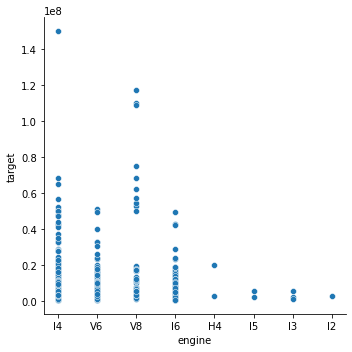

In [730]:
sns.relplot(data=X, x='engine', y='target')

거래량은 4기통 엔진이 많지만, 8기통 엔진이 상대적으로 높은 가격대에 분포합니다.

I4 엔진 차량 중에서 가장 비싸게 팔린 차량은 앞서 살펴본 롤스로이스 고스트입니다.

---

### **transmission**

트랜스미션은 변속장치 데이터입니다.

In [731]:
X['transmission'].nunique()

2

In [732]:
X['transmission'].value_counts()

automatic    965
manual        49
Name: transmission, dtype: int64

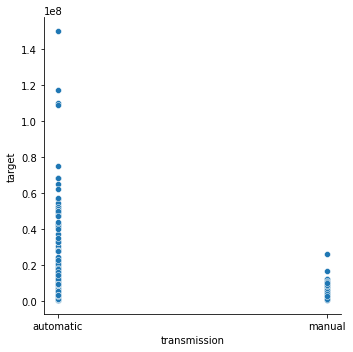

In [733]:
sns.relplot(data=X, x='transmission', y='target')

변속장치는 두 가지 카테고리를 가진 범주형 데이터입니다.

데이터 분포에 별다른 이상치도 보이지 않습니다.

---

### **fuel**

휘발유, 디젤 등의 범주형 데이터입니다.

In [734]:
X['fuel'].nunique()

2

In [735]:
X['fuel'].value_counts()

petrol    970
diesel     44
Name: fuel, dtype: int64

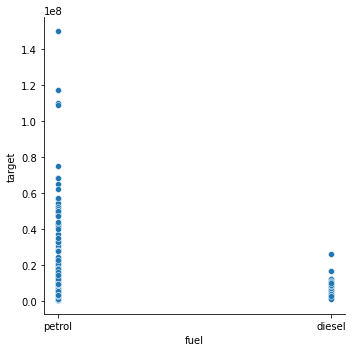

In [736]:
sns.relplot(data=X, x='fuel', y='target')

휘발유 차량이 범용적으로 거래됩니다.

가격 분포에도 이상한 점은 딱히 보이지 않습니다.

---

### **paint**

차량의 색상 데이터입니다.

한국은 보통 유광, 흰색 또는 검은색, 회색 등의 무채색 차량을 선호하는데 나이지리아는 어떨지 모르겠군요.

In [737]:
X['paint'].nunique()

76

In [738]:
X['paint'].value_counts()

Black          292
White          115
Silver         103
Grey            84
Blue            70
              ... 
WINE             1
Silver/grey      1
Ink blue         1
Light blue       1
Off white l      1
Name: paint, Length: 76, dtype: int64

거래량을 보니 나이지리아도 무채색을 선호하는 것 같습니다.

가격 분포를 살펴봅니다.

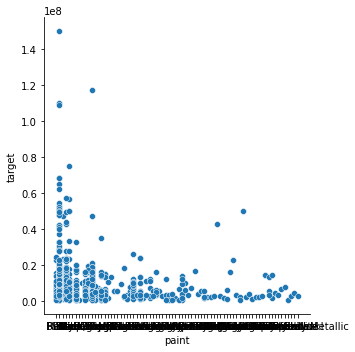

In [739]:
sns.relplot(data=X, x='paint', y='target')

마이너한 색상일수록 가격이 낮아지는 것을 볼 수 있습니다.

마이너하지만 가격이 높은 일부 색상이 있는데, 색상 때문에 가격이 높게 책정된 것인지 아니면 다른 요소가 원인인지는 조금 더 살펴봐야 합니다.

### **year**

제조년도 데이터입니다. 별다른 문제가 없다면 신형일수록 가격이 비싸겠죠.

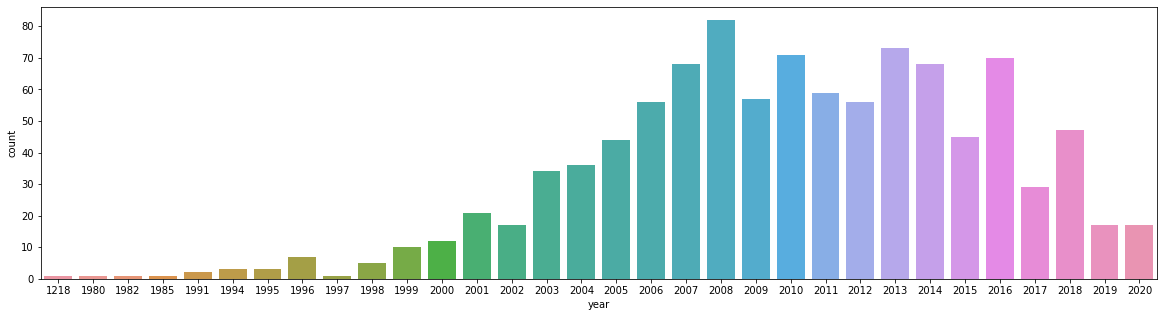

In [740]:
plt.figure(figsize=(20,5))
sns.countplot(data=X, x='year')
plt.show()

1218년에 차가 존재할 리는 없겠죠.

이상치이므로 제거해줍니다.

In [741]:
X.loc[X['year']==1218]

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target
415,415,Mercedes-Benz ATEGO,403461,lagos,locally used,I4,manual,diesel,white,1218,6015000


In [742]:
X = X.drop(415)
X = X.reset_index(drop=True)

이상으로 가볍게 각 컬럼별로 기본적인 EDA를 진행했습니다.

이제 각 컬럼을 모델에 넣을 수 있도록 변환하는 작업이 필요합니다.

물론 해당 작업을 해준 뒤에도 추가로 몇 가지 해볼만한 EDA가 있습니다.

---

## **데이터 변환**

In [743]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1013 entries, 0 to 1012
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1013 non-null   int64 
 1   title         1013 non-null   object
 2   odometer      1013 non-null   int64 
 3   location      1013 non-null   object
 4   isimported    1013 non-null   object
 5   engine        1013 non-null   object
 6   transmission  1013 non-null   object
 7   fuel          1013 non-null   object
 8   paint         1013 non-null   object
 9   year          1013 non-null   int64 
 10  target        1013 non-null   int64 
dtypes: int64(4), object(7)
memory usage: 87.2+ KB


In [744]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            436 non-null    int64 
 1   title         436 non-null    object
 2   odometer      436 non-null    int64 
 3   location      436 non-null    object
 4   isimported    436 non-null    object
 5   engine        436 non-null    object
 6   transmission  436 non-null    object
 7   fuel          436 non-null    object
 8   paint         436 non-null    object
 9   year          436 non-null    int64 
dtypes: int64(3), object(7)
memory usage: 34.2+ KB


결측치는 없고, object 타입의 컬럼들을 변환해주어야 합니다.

---

### **원핫인코딩 1**

In [745]:
test_final = test_data.copy()

In [746]:
X['fuel'].unique()

array(['petrol', 'diesel'], dtype=object)

In [747]:
test_final['fuel'].unique()

array(['petrol', 'diesel'], dtype=object)

In [748]:
X['transmission'].unique()

array(['automatic', 'manual'], dtype=object)

In [749]:
test_final['transmission'].unique()

array(['automatic', 'manual'], dtype=object)


fuel, transmission 컬럼은 별도의 복잡한 처리가 필요없습니다.

기본적인 원핫인코딩만 진행해줍니다.

In [750]:
# X_fuel
fuel_dummies = pd.get_dummies(X['fuel'])
X = pd.concat([X, fuel_dummies], axis=1)
X.drop(['fuel'], axis=1, inplace=True)

# X_transmission
transmission_dummies = pd.get_dummies(X['transmission'])
X = pd.concat([X, transmission_dummies], axis=1)
X.drop(['transmission'], axis=1, inplace=True)

# test_fuel
test_fuel_dummies = pd.get_dummies(test_final['fuel'])
test_final = pd.concat([test_final, test_fuel_dummies], axis=1)
test_final.drop(['fuel'], axis=1, inplace=True)

# test_transmission
test_transmission_dummies = pd.get_dummies(test_final['transmission'])
test_final = pd.concat([test_final, test_transmission_dummies], axis=1)
test_final.drop(['transmission'], axis=1, inplace=True)

print('Done!')

Done!


In [751]:
X.sample(5)

,id,title,odometer,location,isimported,engine,paint,year,target,diesel,petrol,automatic,manual
618,619,Honda Crosstour,156135,adamawa,locally used,V6,Black,2010,2715000,0,1,1,0
247,247,Toyota Sienna,85240,lagos,foreign used,V6,White,2009,3315000,0,1,1,0
49,49,Land Rover Range Rover Sport,32646,lagos,foreign used,I6,White,2014,24015000,0,1,1,0
740,741,Nissan Murano,0,lagos,locally used,V6,Silver,2005,730000,0,1,1,0
798,799,Toyota Corolla,65384,lagos,foreign used,I4,Dark Grey,2010,3425000,0,1,1,0


In [752]:
test_final.head()

,id,title,odometer,location,isimported,engine,paint,year,diesel,petrol,automatic,manual
0,0,Mercedes-Benz C 300,1234,Abuja,New,4-cylinder(I4),White,2017,0,1,1,0
1,1,Honda Accord,29938,Abuja,Foreign Used,4-cylinder(I4),White,2013,0,1,1,0
2,2,Mercedes-Benz S 550,87501,Lagos,Foreign Used,4-cylinder(I4),Black,2012,0,1,1,0
3,3,Toyota Sienna,180894,Lagos,Locally used,6-cylinder(V6),Dark Grey,2001,0,1,1,0
4,4,Toyota Hiace,104814,Lagos,Foreign Used,4-cylinder(I4),White,2000,0,1,1,0


isimported 컬럼과 engine 컬럼도 데이터 분포상으로 별도의 처리가 필요한 것처럼 보이진 않았습니다.

테스트 데이터도 확인해보겠습니다.

In [753]:
X['isimported'].unique()

array(['foreign used', 'new', 'locally used'], dtype=object)

In [754]:
test_final['isimported'] = clean_text(test_final['isimported'])

In [755]:
test_final['isimported'].unique()

array(['new', 'foreign used', 'locally used'], dtype=object)

In [756]:
# X_isimported
X_isimported_dummies = pd.get_dummies(X['isimported'])
X = pd.concat([X, X_isimported_dummies], axis=1)
X.drop(['isimported'], axis=1, inplace=True)

# test_isimported
test_isimported_dummies = pd.get_dummies(test_final['isimported'])
test_final = pd.concat([test_final, test_isimported_dummies], axis=1)
test_final.drop(['isimported'], axis=1, inplace=True)

In [757]:
test_final.head()

,id,title,odometer,location,engine,paint,year,diesel,petrol,automatic,manual,foreign used,locally used,new
0,0,Mercedes-Benz C 300,1234,Abuja,4-cylinder(I4),White,2017,0,1,1,0,0,0,1
1,1,Honda Accord,29938,Abuja,4-cylinder(I4),White,2013,0,1,1,0,1,0,0
2,2,Mercedes-Benz S 550,87501,Lagos,4-cylinder(I4),Black,2012,0,1,1,0,1,0,0
3,3,Toyota Sienna,180894,Lagos,6-cylinder(V6),Dark Grey,2001,0,1,1,0,0,1,0
4,4,Toyota Hiace,104814,Lagos,4-cylinder(I4),White,2000,0,1,1,0,1,0,0


In [758]:
X.head()

,id,title,odometer,location,engine,paint,year,target,diesel,petrol,automatic,manual,foreign used,locally used,new
0,0,Toyota RAV 4,18277,lagos,I4,Red,2016,13665000,0,1,1,0,1,0,0
1,1,Toyota Land Cruiser,10,lagos,I4,Black,2019,33015000,0,1,1,0,0,0,1
2,2,Land Rover Range Rover Evoque,83091,lagos,V6,Red,2012,9915000,0,1,1,0,1,0,0
3,3,Lexus ES 350,91524,lagos,I4,Gray,2007,3815000,0,1,1,0,1,0,0
4,4,Toyota Venza,94177,lagos,V6,Red,2010,7385000,0,1,1,0,1,0,0


In [759]:
X['engine'].unique()

array(['I4', 'V6', 'V8', 'I6', 'H4', 'I5', 'I3', 'I2'], dtype=object)

In [760]:
test_final['engine'].unique()

array(['4-cylinder(I4)', '6-cylinder(V6)', '6-cylinder(I6)',
       '8-cylinder(V8)', '5-cylinder(I5)', '2-cylinder(I2)',
       '12-cylinder(V12)', '3-cylinder(I3)'], dtype=object)

test 데이터에는 12기통 엔진까지 포함돼 있군요.

트레인셋에 12기통 엔진 데이터가 없기 때문에 일단 지금은 원핫인코딩을 하지 않고 변환만 해주겠습니다.


이런 경우엔 컬럼 정리 후 sklearn의 onehotencoder가 제공하는 ignore 기능을 쓰면 됩니다.

In [761]:
test_engine = test_final['engine']
pattern = re.compile('\S\d+')

test_engine_list = []
for i in range(1, len(test_engine)):
    test_engine_list = test_engine_list + pattern.findall(test_engine[i])

test_final['engine'] = test_engine_list
test_final.head()

,id,title,odometer,location,engine,paint,year,diesel,petrol,automatic,manual,foreign used,locally used,new
0,0,Mercedes-Benz C 300,1234,Abuja,I4,White,2017,0,1,1,0,0,0,1
1,1,Honda Accord,29938,Abuja,I4,White,2013,0,1,1,0,1,0,0
2,2,Mercedes-Benz S 550,87501,Lagos,V6,Black,2012,0,1,1,0,1,0,0
3,3,Toyota Sienna,180894,Lagos,I4,Dark Grey,2001,0,1,1,0,0,1,0
4,4,Toyota Hiace,104814,Lagos,I4,White,2000,0,1,1,0,1,0,0


잘 변환됐습니다.

---

### **원핫인코딩 2**

paint 컬럼과 title 컬럼은 조금 생각이 필요합니다.

paint 컬럼부터 살펴보겠습니다.

In [762]:
X['paint'] = clean_text(X['paint'])
X['paint'].nunique()

51

In [763]:
test_final['paint'] = clean_text(test_final['paint'])
test_final['paint'].nunique()

30

일단 기본적인 clean_text 처리를 해준 뒤에도 색상 종류가 51종입니다.

이걸 모두 원핫인코딩하면 훈련 데이터의 컬럼 개수가 80개가 됩니다. 연산량도 늘어나겠죠.

컬럼 개수를 그렇게까지 늘리지 않고 해결할 방법은 없을까요?

In [764]:
X['paint'].unique()

array(['red', 'black', 'gray', 'white', 'blue', 'redl', 'silver',
       'blackred', 'deep blue', 'dark grey', 'brown', 'grey', 'green',
       'purple', 'gold', 'dark blue', 'milk', 'midnight black metal',
       'beige', 'dark ash', 'orange', 'cream', 'dark gray', 'sliver',
       'white orchild pearl', 'dark green', 'yellow', 'light gold',
       'wine', 'whiteblue', 'magnetic gray', 'dark silver', 'silvergrey',
       'ink blue', 'light blue', 'sky blue', 'gery', 'pale brown',
       'whine', 'black and silver', 'light silver', 'black sand pearl',
       'off white', 'ash', 'maroon', 'navy blue', 'super white',
       'ash and black', 'magnetic gray metallic', 'skye blue',
       'off white l'], dtype=object)

In [765]:
test_final['paint'].unique()

array(['white', 'black', 'dark grey', 'red', 'silver', 'blue', 'gray',
       'grey', 'gold', 'green', 'sliver', 'cream', 'brown', 'yellow',
       'dark green', 'white and green', 'light grey', 'maroon', 'wine',
       'ash', 'blac', 'dark blue', 'dark ash', 'golf', 'navy blue',
       'indigo ink pearl', 'grey and black', 'classic silver metf',
       'beige', 'mint green'], dtype=object)

redl, gray, off white l, skye blue 등의 오타도 보이고 비슷한 색상끼리 그룹핑도 가능할 것 같습니다.

마침 [코드 공유란](https://dacon.io/competitions/official/235901/codeshare/5097?page=1&dtype=recent)에 올라와 있는 코드를 활용하면 되겠습니다.

In [766]:
tmp = X['paint']

map_list = {i : i for i in np.unique(tmp)}

tmp_map = {'off white l':'off white',
            'redl': 'red',
            'gray': 'grey',
            'gery': 'grey',
            'skye blue':'sky blue',
            'sliver':'silver',
            'whine':'white'}

for k in tmp_map.keys():
  v = tmp_map[k]
  map_list[k] = v

X['paint'] = X['paint'].map(map_list)

In [767]:
X['paint'].unique()

array(['red', 'black', 'grey', 'white', 'blue', 'silver', 'blackred',
       'deep blue', 'dark grey', 'brown', 'green', 'purple', 'gold',
       'dark blue', 'milk', 'midnight black metal', 'beige', 'dark ash',
       'orange', 'cream', 'dark gray', 'white orchild pearl',
       'dark green', 'yellow', 'light gold', 'wine', 'whiteblue',
       'magnetic gray', 'dark silver', 'silvergrey', 'ink blue',
       'light blue', 'sky blue', 'pale brown', 'black and silver',
       'light silver', 'black sand pearl', 'off white', 'ash', 'maroon',
       'navy blue', 'super white', 'ash and black',
       'magnetic gray metallic'], dtype=object)

In [768]:
# dark, deep, ink, light, magnetic, metallic, midnight, metal, navy, off, pale, sky, super
def clean_text_add(texts): 
    corpus = [] 
    for i in range(0, len(texts)): 
        review = re.sub(r'\s+', ' ', texts[i]) #extra space 제거
        review = re.sub(r'<[^>]+>','',review) #Html tags 제거
        review = re.sub('dark|deep|ink|light|magnetic|metallic|midnight|metal|navy|off|pale|sky|super','',review)
        review = re.sub(r'\s+', ' ', review) #spaces 제거
        review = re.sub(r"^\s+", '', review) #space from start 제거
        review = re.sub(r'\s+$', '', review) #space from the end 제거
        review = re.sub(r'_', ' ', review) #space from the end 제거
        #review = re.sub(r'l', '', review)
        corpus.append(review) 
        
    return corpus

In [769]:
tmp = X['paint']
tmp = clean_text_add(tmp) #메소드 적용
X['paint'] = tmp
np.unique(tmp)

array(['ash', 'ash and black', 'beige', 'black', 'black and silver',
       'black sand pearl', 'blackred', 'blue', 'brown', 'cream', 'gold',
       'gray', 'green', 'grey', 'maroon', 'milk', 'orange', 'purple',
       'red', 'silver', 'silvergrey', 'white', 'white orchild pearl',
       'whiteblue', 'wine', 'yellow'], dtype='<U19')

In [770]:
tmp_test = test_final['paint']
tmp_test = clean_text_add(tmp_test) #메소드 적용
test_final['paint'] = tmp_test
np.unique(tmp_test)

array(['ash', 'beige', 'blac', 'black', 'blue', 'brown',
       'classic silver metf', 'cream', 'gold', 'golf', 'gray', 'green',
       'grey', 'grey and black', 'indigo pearl', 'maroon', 'mint green',
       'red', 'silver', 'sliver', 'white', 'white and green', 'wine',
       'yellow'], dtype='<U19')

In [771]:
map_list = {i : i for i in np.unique(tmp)}

tmp_map = {'ash':'black',
            'ash and black': 'black',
           'beige': 'white',
           'black and silver':'black',
           'black sand pearl': 'black',
           'blackred': 'black',
           'cream': 'white',
           'maroon': 'brown',
           'milk':'white',
           'purple':'red',
           'silver':'grey',
           'silvergrey':'grey',
           'white orchild pearl':'white',
           'whiteblue': 'blue',
           'wine':'red',
           'orange':'yellow',
           'gray':'grey',
           'white and green':'white',
           'blac':'black',
           'classic silver metf':'grey',
           'cream':'white',
           'golf':'gold',
           'grey and black':'grey',
           'indigo pearl':'blue',
           'mint green':'green',
           'sliver':'silver'
}

for k in tmp_map.keys():
  v = tmp_map[k]
  map_list[k] = v

X['paint'] = X['paint'].map(map_list)

In [772]:
map_list = {i : i for i in np.unique(tmp_test)}
for k in tmp_map.keys():
  v = tmp_map[k]
  map_list[k] = v

test_final['paint'] = test_final['paint'].map(map_list)

In [773]:
X['paint'].unique()

array(['red', 'black', 'grey', 'white', 'blue', 'brown', 'green', 'gold',
       'yellow'], dtype=object)

In [774]:
test_final['paint'].unique()

array(['white', 'black', 'grey', 'red', 'blue', 'gold', 'green', 'silver',
       'brown', 'yellow'], dtype=object)

잘 정리되었습니다.

location 컬럼도 같은 요령으로 처리해 주겠습니다.

In [775]:
X['location'].unique()

array(['lagos', 'abuja', 'ogun', 'fct', 'accra', 'other', 'abia',
       'adamawa'], dtype=object)

In [776]:
test_final['location'] = clean_text(test_final['location'])
test_final['location'].unique()

array(['abuja', 'lagos', 'ogun', 'mushin', 'other', 'arepo ogun', 'abia'],
      dtype=object)

test set에서 처음보는 도시가 등장합니다.

---

### **title = brand + vehicle_type**

title 컬럼은 브랜드와 세부 차종으로 나눠서 진행합니다.

브랜드에 따라 차량 가격이 바뀌기도 하고, 같은 브랜드 내에서도 세부 차종에 따라 가격이 또 바뀌기 때문입니다.

In [777]:
low_20 = vehicle_popularity[181:201]
low_20

Man Truck 18.44            1
Mercedes-Benz 220          1
Ford Focus                 1
Mercedes-Benz ATEGO        1
Mercedes-Benz ML 320       1
Nissan Xterra              1
DAF FA 55. 180             1
IVECO EUROTECH 7.50E-16    1
Toyota Coaster             1
Volvo FL6                  1
Toyota Dyna                1
BMW 740                    1
Mercedes-Benz S 450        1
Honda Ridgeline            1
Mercedes-Benz 320          1
Volkswagen Golf            1
Nissan Versa               1
Scania P94 FLATBED         1
Mercedes-Benz GLA 250      1
Acura ZDX                  1
Name: title, dtype: int64

In [778]:
top_10

Toyota Camry         129
Toyota Corolla       108
Toyota Highlander     50
Toyota Sienna         49
Toyota RAV 4          40
Honda Accord          38
Lexus RX 350          33
Lexus ES 350          24
Toyota Venza          16
Lexus GX 460          16
Name: title, dtype: int64

In [779]:
X['title'].nunique()

201

In [780]:
test_final['title'].nunique()

124

In [781]:
X['title'].unique()

array(['Toyota RAV 4', 'Toyota Land Cruiser',
       'Land Rover Range Rover Evoque', 'Lexus ES 350', 'Toyota Venza',
       'Toyota Corolla', 'Land Rover Range Rover Sport', 'Pontiac Vibe',
       'Toyota Tacoma', 'Lexus RX 350', 'Ford Escape', 'Honda Civic',
       'Volvo XC90', 'BMW 750', 'Infiniti JX', 'Honda Accord',
       'Mercedes-Benz ML 350', 'Toyota Camry', 'Hyundai Azera',
       'Lexus GX 460', 'BMW 325', 'Toyota Sienna', 'Honda Fit',
       'Honda CR-V', 'Hyundai Tucson', 'Ford Transit', 'Jaguar XJ8',
       'BMW X6', 'Mercedes-Benz C 300', 'Mitsubishi Galant',
       'Mercedes-Benz GL 450', 'Lexus RX 300', 'Toyota Highlander',
       'Mitsubishi CANTER PICK UP', 'Nissan Titan', 'Lexus IS 250',
       'Mercedes-Benz 200', 'Toyota Sequoia', 'Ford Explorer',
       'Hyundai ix35', 'Mack CH613 CONVENTIONAL CAB', 'Lexus CT 200h',
       'Lexus LX 570', 'Toyota Avensis', 'Toyota 4-Runner',
       'Mercedes-Benz GLE 350', 'Mercedes-Benz E 300', 'Toyota Avalon',
       'Chevrole

In [782]:
test_final['title'].unique()

array(['Mercedes-Benz C 300', 'Honda Accord', 'Mercedes-Benz S 550',
       'Toyota Sienna', 'Toyota Hiace', 'Toyota Corolla',
       'Iveco EUROCARGO 120e18', 'Mercedes-Benz GLE 350',
       'Toyota Highlander', 'Toyota Hilux', 'Toyota Camry',
       'Mercedes-Benz C 180', 'Lexus ES 350', 'Honda Fit',
       'Toyota Matrix', 'Toyota Venza', 'Lexus IS 250', 'Nissan Primera',
       'Volkswagen Sharan', 'Jeep Wrangler', 'Volkswagen Golf',
       'Mercedes-Benz 814', 'Nissan Sentra', 'Volkswagen Passat',
       'Mercedes-Benz GLK 350', 'Lexus RX 350', 'Ford Mondeo', 'BMW X3',
       'Mack CXN613 CAB BEHIND ENGINE', 'Toyota RAV 4',
       'Land Rover Discovery', 'Toyota Avalon', 'Lexus GX 460',
       'Hyundai Santa Fe', 'Peugeot 206', 'Volvo FL7',
       'Mercedes-Benz C 320', 'Hyundai Sonata', 'Infiniti FX',
       'Honda Civic', 'Mercedes-Benz CLS 500', 'Mercedes-Benz GLK 300',
       'Acura RDX', 'Mercedes-Benz G 550', 'BMW 535', 'Acura TL',
       'Nissan Xterra', 'Land Rover Range R

맨 처음 단어가 브랜드고, 뒤에 세부 차종 정보가 옵니다.

데이콘에서 제공한 함수를 활용하여 brand 컬럼을 생성해줍니다.

Land Rover는 Land-Rover로 미리 변환해줍니다.

In [783]:
brand = []
for i in range(len(X)):
    review = re.sub(r'Land Rover', 'Land-Rover', X['title'][i])
    brand.append(review)

X['title'] = brand
X.head()

,id,title,odometer,location,engine,paint,year,target,diesel,petrol,automatic,manual,foreign used,locally used,new
0,0,Toyota RAV 4,18277,lagos,I4,red,2016,13665000,0,1,1,0,1,0,0
1,1,Toyota Land Cruiser,10,lagos,I4,black,2019,33015000,0,1,1,0,0,0,1
2,2,Land-Rover Range Rover Evoque,83091,lagos,V6,red,2012,9915000,0,1,1,0,1,0,0
3,3,Lexus ES 350,91524,lagos,I4,grey,2007,3815000,0,1,1,0,1,0,0
4,4,Toyota Venza,94177,lagos,V6,red,2010,7385000,0,1,1,0,1,0,0


In [784]:
brand_test = []
for i in range(len(test_final)):
    review = re.sub(r'Land Rover', 'Land-Rover', test_final['title'][i])
    brand_test.append(review)

test_final['title'] = brand_test
test_final.head()

,id,title,odometer,location,engine,paint,year,diesel,petrol,automatic,manual,foreign used,locally used,new
0,0,Mercedes-Benz C 300,1234,abuja,I4,white,2017,0,1,1,0,0,0,1
1,1,Honda Accord,29938,abuja,I4,white,2013,0,1,1,0,1,0,0
2,2,Mercedes-Benz S 550,87501,lagos,V6,black,2012,0,1,1,0,1,0,0
3,3,Toyota Sienna,180894,lagos,I4,grey,2001,0,1,1,0,0,1,0
4,4,Toyota Hiace,104814,lagos,I4,white,2000,0,1,1,0,1,0,0


In [785]:
X['title'].apply(lambda x : x.split(" ")[0])
X['brand'] = X['title'].apply(lambda x : x.split(" ")[0])
X.head()

,id,title,odometer,location,engine,paint,year,target,diesel,petrol,automatic,manual,foreign used,locally used,new,brand
0,0,Toyota RAV 4,18277,lagos,I4,red,2016,13665000,0,1,1,0,1,0,0,Toyota
1,1,Toyota Land Cruiser,10,lagos,I4,black,2019,33015000,0,1,1,0,0,0,1,Toyota
2,2,Land-Rover Range Rover Evoque,83091,lagos,V6,red,2012,9915000,0,1,1,0,1,0,0,Land-Rover
3,3,Lexus ES 350,91524,lagos,I4,grey,2007,3815000,0,1,1,0,1,0,0,Lexus
4,4,Toyota Venza,94177,lagos,V6,red,2010,7385000,0,1,1,0,1,0,0,Toyota


In [786]:
test_final['title'].apply(lambda x : x.split(" ")[0])
test_final['brand'] = test_final['title'].apply(lambda x : x.split(" ")[0])
test_final.head()

,id,title,odometer,location,engine,paint,year,diesel,petrol,automatic,manual,foreign used,locally used,new,brand
0,0,Mercedes-Benz C 300,1234,abuja,I4,white,2017,0,1,1,0,0,0,1,Mercedes-Benz
1,1,Honda Accord,29938,abuja,I4,white,2013,0,1,1,0,1,0,0,Honda
2,2,Mercedes-Benz S 550,87501,lagos,V6,black,2012,0,1,1,0,1,0,0,Mercedes-Benz
3,3,Toyota Sienna,180894,lagos,I4,grey,2001,0,1,1,0,0,1,0,Toyota
4,4,Toyota Hiace,104814,lagos,I4,white,2000,0,1,1,0,1,0,0,Toyota


In [787]:
X['brand'].unique()

array(['Toyota', 'Land-Rover', 'Lexus', 'Pontiac', 'Ford', 'Honda',
       'Volvo', 'BMW', 'Infiniti', 'Mercedes-Benz', 'Hyundai', 'Jaguar',
       'Mitsubishi', 'Nissan', 'Mack', 'Chevrolet', 'Mazda', 'Lincoln',
       'Kia', 'Volkswagen', 'Acura', 'DAF', 'Man', 'Isuzu', 'IVM',
       'Porsche', 'MINI', 'Dodge', 'GMC', 'Iveco', 'Scania', 'GAC',
       'IVECO', 'Peugeot', 'Rolls-Royce', 'MAN-VOLKSWAGEN', 'Jeep',
       'ALPINA', 'Bentley', 'JMC', 'Audi'], dtype=object)

In [788]:
test_final['brand'].unique()

array(['Mercedes-Benz', 'Honda', 'Toyota', 'Iveco', 'Lexus', 'Nissan',
       'Volkswagen', 'Jeep', 'Ford', 'BMW', 'Mack', 'Land-Rover',
       'Hyundai', 'Peugeot', 'Volvo', 'Infiniti', 'Acura', 'Man', 'Fiat',
       'MINI', 'DAF', 'Mazda', 'Porsche', 'Mitsubishi', 'Chevrolet',
       'Kia', 'Pontiac', 'Rolls-Royce'], dtype=object)

마찬가지로 차종 컬럼도 생성합니다.

In [789]:
veh_info = X['brand']
X['veh_type'] = X['title']

for i in range(len(X)):
    pattern = veh_info[i]
    X['veh_type'][i] = X['title'][i].split(pattern)[1]

X.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,title,odometer,location,engine,paint,year,target,diesel,petrol,automatic,manual,foreign used,locally used,new,brand,veh_type
0,0,Toyota RAV 4,18277,lagos,I4,red,2016,13665000,0,1,1,0,1,0,0,Toyota,RAV 4
1,1,Toyota Land Cruiser,10,lagos,I4,black,2019,33015000,0,1,1,0,0,0,1,Toyota,Land Cruiser
2,2,Land-Rover Range Rover Evoque,83091,lagos,V6,red,2012,9915000,0,1,1,0,1,0,0,Land-Rover,Range Rover Evoque
3,3,Lexus ES 350,91524,lagos,I4,grey,2007,3815000,0,1,1,0,1,0,0,Lexus,ES 350
4,4,Toyota Venza,94177,lagos,V6,red,2010,7385000,0,1,1,0,1,0,0,Toyota,Venza


In [790]:
test_veh_info = test_final['brand']
test_final['veh_type'] = test_final['title']

for i in range(len(test_final)):
    pattern = test_veh_info[i]
    test_final['veh_type'][i] = test_final['title'][i].split(pattern)[1]

test_final.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,title,odometer,location,engine,paint,year,diesel,petrol,automatic,manual,foreign used,locally used,new,brand,veh_type
0,0,Mercedes-Benz C 300,1234,abuja,I4,white,2017,0,1,1,0,0,0,1,Mercedes-Benz,C 300
1,1,Honda Accord,29938,abuja,I4,white,2013,0,1,1,0,1,0,0,Honda,Accord
2,2,Mercedes-Benz S 550,87501,lagos,V6,black,2012,0,1,1,0,1,0,0,Mercedes-Benz,S 550
3,3,Toyota Sienna,180894,lagos,I4,grey,2001,0,1,1,0,0,1,0,Toyota,Sienna
4,4,Toyota Hiace,104814,lagos,I4,white,2000,0,1,1,0,1,0,0,Toyota,Hiace


---

### **원핫인코딩 3 (ignore)**

In [791]:
ohe = OneHotEncoder(handle_unknown = 'ignore')

x_copy = X.drop(['id', 'title', 'target'], axis=1).copy()
test_copy = test_final.drop(['id', 'title'], axis=1).copy()

ohe.fit(x_copy)

x_encoded = ohe.transform(x_copy)
test_encoded = ohe.transform(test_copy)

x_encoded = pd.DataFrame(x_encoded.todense(), columns=ohe.get_feature_names_out())
test_encoded = pd.DataFrame(test_encoded.todense(), columns=ohe.get_feature_names_out())


In [792]:
x_encoded.shape

(1013, 1296)

In [793]:
test_encoded.shape

(436, 1296)

---

## **validation set 생성**

In [937]:
# 최종 학습 셋
train_final = x_encoded.copy()
y = X.target

# y값에 로그 취하기
y = np.log1p(y)


random_state=2022

x_train, x_test, y_train, y_test = tts(train_final, y, random_state=random_state, test_size=0.2)

In [880]:
x_train.shape

(810, 1296)

In [881]:
x_test.shape

(203, 1296)

In [882]:
y_train.shape

(810,)

In [883]:
y_test.shape

(203,)

---

## **모델링 & 훈련**

In [893]:
# 모델 정의
gboost = GradientBoostingRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, lightgbm, rdforest]

print('Done!')

Done!


In [894]:
# 평가 함수 생성
def nmae(true, pred):

    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    
    return score

In [895]:
# 모델링 함수 생성
def modeling(models, train, y):

    df = {}
    for model in models:

        # 모델 이름 획득
        model_name = model.__class__.__name__

        # 데이터셋 분리
        x_train, x_test, y_train, y_test = tts(train, y, random_state=random_state, test_size=0.2)

        # 모델 학습
        model.fit(x_train, y_train)

        # 예측
        y_pred = model.predict(x_test)

        # 예측 결과의 nmae값 저장
        df[model_name] = nmae(y_test, y_pred)

        # df에 내림차순으로 저장
        score_df = pd.DataFrame(df, index=['MAE']).T.sort_values('MAE', ascending=False)
    
    print(df)

In [896]:
# test
modeling(models, train_final, y)

{'GradientBoostingRegressor': 0.019105988438094898, 'LGBMRegressor': 0.02423857465474319, 'RandomForestRegressor': 0.018199023880485308}


---

## **GridSearch**

GridSearch는 모델의 적합한 하이퍼파라미터를 찾아주는 모듈입니다.

In [897]:
param_grid = {
    'n_estimators': [10, 50, 100],  # n_estimators 값 2개 지정 (50, 100) / estimator 객체 개수가 10개, 50개, 100개일때
    'max_depth': [1, 10],       # max_depth 값 2개 지정 (1, 10) / 최대 차수가 1일때와 10개일때
}

# LightGBM
model = LGBMRegressor(random_state=random_state)

grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_absolute_error', \
                        cv=5, verbose=1, n_jobs=5)              # 매회 교차검증 5회씩 반복

grid_model.fit(train_final, y)

# 결과 확인
grid_model.cv_results_


Fitting 5 folds for each of 6 candidates, totalling 30 fits


{'mean_fit_time': array([0.13633065, 0.14539585, 0.1585978 , 0.13987455, 0.19137712,
        0.22453027]),
 'mean_score_time': array([0.04075937, 0.03507881, 0.0420424 , 0.0422904 , 0.04479799,
        0.02468495]),
 'mean_test_score': array([-0.70056256, -0.60903751, -0.53640986, -0.53661204, -0.39528907,
        -0.39137043]),
 'param_max_depth': masked_array(data=[1, 1, 1, 10, 10, 10],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[10, 50, 100, 10, 50, 100],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 10},
  {'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 10},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'rank_test_score': array([6, 5, 3, 4, 2, 1], dtype=i

In [898]:
# 결과 평가

# 파라미터 조합 가져오기
params = grid_model.cv_results_['params']
print(params)

# 점수 결과값 가져오기
score = grid_model.cv_results_['mean_test_score']
print(score)

# 이제 합쳐주면 됩니다
result = pd.DataFrame(params)
result['score'] = score
result['MAE'] = (-1 * result['score'])
result

result


[{'max_depth': 1, 'n_estimators': 10}, {'max_depth': 1, 'n_estimators': 50}, {'max_depth': 1, 'n_estimators': 100}, {'max_depth': 10, 'n_estimators': 10}, {'max_depth': 10, 'n_estimators': 50}, {'max_depth': 10, 'n_estimators': 100}]
[-0.70056256 -0.60903751 -0.53640986 -0.53661204 -0.39528907 -0.39137043]


,max_depth,n_estimators,score,MAE
0,1,10,-0.700563,0.700563
1,1,50,-0.609038,0.609038
2,1,100,-0.536410,0.536410
3,10,10,-0.536612,0.536612
4,10,50,-0.395289,0.395289
5,10,100,-0.391370,0.391370


nmae = mean/mae 이므로 당연히 mae 값이 클수록 nmae 값이 낮게 나올 겁니다.

따라서 max_depth 1, n_estimators=10 일때 LGBMRegressor에 대해 최적의 파라미터 값이 됩니다.

 나머지 모델에 대해서도 확인해보겠습니다.

In [899]:
# GradientBoostingRegressor
model2 = GradientBoostingRegressor(random_state=random_state)

grid_model2 = GridSearchCV(model2, param_grid=param_grid, \
                        scoring='neg_mean_absolute_error', \
                        cv=5, verbose=1, n_jobs=5)              # 매회 교차검증 5회씩 반복

grid_model2.fit(train_final, y)

# 결과 확인
grid_model2.cv_results_

# 결과 평가
# 파라미터 조합 가져오기
params2 = grid_model2.cv_results_['params']
print(params2)

# 점수 결과값 가져오기
score2 = grid_model2.cv_results_['mean_test_score']
print(score2)

result2 = pd.DataFrame(params2)
result2['score'] = score2
result2['MAE'] = (-1 * result2['score'])
result2

result2

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[{'max_depth': 1, 'n_estimators': 10}, {'max_depth': 1, 'n_estimators': 50}, {'max_depth': 1, 'n_estimators': 100}, {'max_depth': 10, 'n_estimators': 10}, {'max_depth': 10, 'n_estimators': 50}, {'max_depth': 10, 'n_estimators': 100}]
[-0.70263057 -0.60219372 -0.51646178 -0.45972756 -0.29246263 -0.28050615]


,max_depth,n_estimators,score,MAE
0,1,10,-0.702631,0.702631
1,1,50,-0.602194,0.602194
2,1,100,-0.516462,0.516462
3,10,10,-0.459728,0.459728
4,10,50,-0.292463,0.292463
5,10,100,-0.280506,0.280506


In [900]:
# RandomForestRegressor
model3 = RandomForestRegressor(random_state=random_state)

grid_model3 = GridSearchCV(model3, param_grid=param_grid, \
                        scoring='neg_mean_absolute_error', \
                        cv=5, verbose=1, n_jobs=5)              # 매회 교차검증 5회씩 반복

grid_model3.fit(train_final, y)

# 결과 확인
grid_model3.cv_results_

# 결과 평가
# 파라미터 조합 가져오기
params3 = grid_model3.cv_results_['params']
print(params3)

# 점수 결과값 가져오기
score3 = grid_model3.cv_results_['mean_test_score']
print(score3)

result3 = pd.DataFrame(params3)
result3['score'] = score3
result3['MAE'] = (-1 * result3['score'])
result3

result3

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[{'max_depth': 1, 'n_estimators': 10}, {'max_depth': 1, 'n_estimators': 50}, {'max_depth': 1, 'n_estimators': 100}, {'max_depth': 10, 'n_estimators': 10}, {'max_depth': 10, 'n_estimators': 50}, {'max_depth': 10, 'n_estimators': 100}]
[-0.70470359 -0.70526172 -0.70526506 -0.37853509 -0.37385516 -0.37413996]


,max_depth,n_estimators,score,MAE
0,1,10,-0.704704,0.704704
1,1,50,-0.705262,0.705262
2,1,100,-0.705265,0.705265
3,10,10,-0.378535,0.378535
4,10,50,-0.373855,0.373855
5,10,100,-0.374140,0.374140


---

### **그래서 어떤 모델이 가장 좋은가?**

수치만으로 보면 RandomForestRegressor가 제일 좋은 성능을 보입니다.

soft-voting 앙상블을 할 경우엔 평균을 내므로 결과의 신뢰도가 높아지는 장점이 있습니다.

In [926]:
# 모델 생성
# LGBMRegressor
model_lgbm = LGBMRegressor(max_depth=1, n_estimators=10, random_state=random_state)

# RandomForestRegressor
model_rf = RandomForestRegressor(max_depth=1, n_estimators=10, random_state=random_state)

# GradientBoostingRegressor
model_gb = GradientBoostingRegressor(max_depth=1, n_estimators=10, random_state=random_state)

print('Done!')

Done!


In [927]:
# 모델 훈련
# LGBMRegressor
model_lgbm.fit(train_final, y)

# RandomForestRegressor
model_rf.fit(train_final, y)

# GradientBoostingRegressor
model_gb.fit(train_final, y)

print('Done!')

Done!


In [928]:
# 예측값 생성
# LGBMRegressor
lgbm_pred = expm1(model_lgbm.predict(x_test))

# RandomForestRegressor
rf_pred = expm1(model_rf.predict(x_test))

# GradientBoostingRegressor
gb_pred = expm1(model_gb.predict(x_test))

In [929]:
final_set = (lgbm_pred + rf_pred + gb_pred) /3

In [930]:
final_set

array([ 7624623.09491976,  7624623.09491976,  7624623.09491976,
        7624623.09491976,  9103858.73994686,  7624623.09491976,
        7624623.09491976,  7624623.09491976,  7624623.09491976,
        7624623.09491976,  7624623.09491976,  9103858.73994686,
        8581068.83361056,  7624623.09491976,  7624623.09491976,
        7624623.09491976,  7624623.09491976,  7624623.09491976,
        7624623.09491976,  7624623.09491976,  7624623.09491976,
        7624623.09491976,  7624623.09491976,  7624623.09491976,
        7624623.09491976,  7624623.09491976,  7624623.09491976,
        7624623.09491976,  7624623.09491976,  7624623.09491976,
        7624623.09491976,  7624623.09491976,  7624623.09491976,
        7624623.09491976,  7624623.09491976,  7624623.09491976,
        7624623.09491976,  8581068.83361056,  8665031.36384086,
        7624623.09491976,  7624623.09491976,  7624623.09491976,
        7624623.09491976,  7624623.09491976,  7624623.09491976,
        7624623.09491976,  7624623.09491

정상적으로 작동합니다.

최종 예측치를 산출하겠습니다.

In [932]:
# 최종 예측값 생성
# LGBMRegressor
lgbm_pred_final = np.expm1(model_lgbm.predict(test_encoded))

# RandomForestRegressor
rf_pred_final = expm1(model_rf.predict(test_encoded))

# GradientBoostingRegressor
gb_pred_final = expm1(model_gb.predict(test_encoded))

final_submission = (lgbm_pred_final + rf_pred_final + gb_pred_final) /3

In [933]:
final_submission[0:5]

array([17302904.86905983,  7624623.09491976,  7624623.09491976,
        7624623.09491976,  7624623.09491976])

---

## **제출용 파일 생성**

In [934]:
submission = pd.read_csv('/content/drive/MyDrive/Dacon/중고차 가격예측/sample_submission.csv')
submission.head()

,id,target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [935]:
submission['target'] = final_submission
submission.head()

,id,target
0,0,1.730290e+07
1,1,7.624623e+06
2,2,7.624623e+06
3,3,7.624623e+06
4,4,7.624623e+06


In [936]:
submission.to_csv('/content/drive/MyDrive/Dacon/중고차 가격예측/submit5.csv', index=False)